In [1]:
%load_ext autoreload
%autoreload 2

In [25]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import shutil
import pandas as pd
import scipy.stats

import exdir
import expipe
from distutils.dir_util import copy_tree
import septum_mec
import septum_mec.analysis.data_processing as dp
import septum_mec.analysis.registration
from septum_mec.analysis.plotting import despine, plot_bootstrap_timeseries, violinplot, savefig
from phase_precession import cl_corr
from spike_statistics.core import permutation_resampling_test
import matplotlib.mlab as mlab
import scipy.signal as ss
from scipy.interpolate import interp1d
from skimage import measure
from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()
import scipy.signal as ss


from tqdm.notebook import tqdm_notebook as tqdm
tqdm.pandas()

import pycwt

In [34]:
plt.rcParams['figure.dpi'] = 150
figsize_violin = (1.7, 3)
figsize_speed = (4, 3)
plt.rc('axes', titlesize=10)

In [26]:
project_path = dp.project_path()
project = expipe.get_project(project_path)
actions = project.actions

output_path = pathlib.Path("output") / "lfp_speed"
(output_path / "statistics").mkdir(exist_ok=True, parents=True)
(output_path / "figures").mkdir(exist_ok=True, parents=True)

In [6]:
data_action = actions['lfp_speed']
output = exdir.File(
    data_action.data_path('results'),
    plugins = [exdir.plugins.git_lfs, exdir.plugins.quantities])

ignore = ['wavelet_power', 'wavelet_freqs', 'signal']
results = []
for group in output.values():
    d = group.attrs.to_dict()
    d.update({k: np.array(v.data) for k, v in group.items() if k not in ignore})
    results.append(d)
results = pd.DataFrame(results)

In [7]:
results.head()

,freq_score,sample_rate,power_score,action,channel_group,max_speed,min_speed,position_low_pass_frequency,mean_freq,mean_power,speed,speed_bins,theta_freq,theta_power
0,0.191729,1000.0,0.432532,1833-010719-1,0,1,0.02,6,"[7.154332133229601, 7.106500202042717, 7.13862...","[18.005621200653046, 18.66435212100411, 20.504...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.799999999999997, 6.799999999999997, 6.79999...","[3.990633076071412, 3.992883430179942, 3.99513..."
1,0.255882,1000.0,0.434938,1833-010719-1,1,1,0.02,6,"[7.035831237674811, 7.05973079549096, 7.120455...","[16.966011451769536, 17.60417640800431, 19.452...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.799999999999997, 6.799999999999997, 6.79999...","[3.649171825378523, 3.6511305369806806, 3.6530..."
2,0.169116,1000.0,0.338942,1833-010719-1,2,1,0.02,6,"[7.156957284750235, 7.121730043055997, 7.17760...","[14.747162413722597, 15.548073560884317, 16.81...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.799999999999997, 6.799999999999997, 6.79999...","[3.069575227276876, 3.0713927350182493, 3.0732..."
3,0.071480,1000.0,0.141405,1833-010719-1,3,1,0.02,6,"[7.256682286107137, 7.237350035531646, 7.27254...","[13.017027147293039, 12.651121743582284, 13.91...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.399999999999999, 6.399999999999999, 6.39999...","[1.9508693636836856, 1.9523977795413874, 1.953..."
4,0.216792,1000.0,-0.012191,1833-010719-1,4,1,0.02,6,"[7.095817125902336, 7.050223640391819, 7.12869...","[32.456068185302364, 23.01562486642484, 21.395...","[0.02795137493203615, 0.0283076211590443, 0.02...","[0.02, 0.04, 0.06, 0.08, 0.1, 0.12000000000000...","[6.399999999999999, 6.399999999999999, 6.39999...","[1.2545438245339104, 1.2553897239251606, 1.256..."


In [8]:
identify_neurons = actions['identify-neurons']
sessions = pd.read_csv(identify_neurons.data_path('sessions'))

In [9]:
results = results.merge(sessions, on='action')

In [10]:
results.head()

,freq_score,sample_rate,power_score,action,channel_group,max_speed,min_speed,position_low_pass_frequency,mean_freq,mean_power,...,i,ii,session,stim_location,stimulated,tag,date,entity_date,Hz11,Hz30
0,0.191729,1000.0,0.432532,1833-010719-1,0,1,0.02,6,"[7.154332133229601, 7.106500202042717, 7.13862...","[18.005621200653046, 18.66435212100411, 20.504...",...,True,False,1,NaN,False,baseline i,10719,1833-010719,True,False
1,0.255882,1000.0,0.434938,1833-010719-1,1,1,0.02,6,"[7.035831237674811, 7.05973079549096, 7.120455...","[16.966011451769536, 17.60417640800431, 19.452...",...,True,False,1,NaN,False,baseline i,10719,1833-010719,True,False
2,0.169116,1000.0,0.338942,1833-010719-1,2,1,0.02,6,"[7.156957284750235, 7.121730043055997, 7.17760...","[14.747162413722597, 15.548073560884317, 16.81...",...,True,False,1,NaN,False,baseline i,10719,1833-010719,True,False
3,0.071480,1000.0,0.141405,1833-010719-1,3,1,0.02,6,"[7.256682286107137, 7.237350035531646, 7.27254...","[13.017027147293039, 12.651121743582284, 13.91...",...,True,False,1,NaN,False,baseline i,10719,1833-010719,True,False
4,0.216792,1000.0,-0.012191,1833-010719-1,4,1,0.02,6,"[7.095817125902336, 7.050223640391819, 7.12869...","[32.456068185302364, 23.01562486642484, 21.395...",...,True,False,1,NaN,False,baseline i,10719,1833-010719,True,False


In [11]:
results = results.query('stim_location!="mecl" and stim_location!="mecr"')

In [13]:
def action_group(row):
    a = int(row.channel_group in [0,1,2,3])
    return f'{row.action}-{a}'
results['action_side_a'] = results.apply(action_group, axis=1)

In [14]:
lfp_results_hemisphere = results.sort_values(
    by=['action_side_a', 'channel_group'], ascending=[True, False]
).drop_duplicates(subset='action_side_a', keep='first')
lfp_results_hemisphere.loc[:,['action_side_a','channel_group', 'min_speed']].head()

,action_side_a,channel_group,min_speed
7,1833-010719-1-0,7,0.02
3,1833-010719-1-1,3,0.02
15,1833-010719-2-0,7,0.02
11,1833-010719-2-1,3,0.02
23,1833-020719-1-0,7,0.02


In [35]:
colors = ['#1b9e77','#d95f02','#7570b3','#e7298a']
labels = ['Baseline I', '11 Hz', 'Baseline II', '30 Hz']
# Hz11 means that the baseline session was indeed before an 11 Hz session
queries = ['baseline and i and Hz11', 'frequency==11', 'baseline and ii and Hz30', 'frequency==30']

In [16]:
def make_entity_date_side(row):
    s = row.action_side_a.split('-')
    del s[2]
    return '-'.join(s)

In [17]:
lfp_results_hemisphere['entity_date_side'] = lfp_results_hemisphere.apply(make_entity_date_side, axis=1)

In [18]:
from functools import reduce

In [19]:
keys = [
    'freq_score',
    'power_score',
    'speed_bins',
    'mean_freq',
    'mean_power'
]

results = {}
for key in keys:
    results[key] = list()
    for query, label in zip(queries, labels):
        values = lfp_results_hemisphere.query(query).loc[:,['entity_date_side', key]]
        results[key].append(values.rename({key: label}, axis=1))
        
for key, val in results.items():
    df = reduce(lambda  left,right: pd.merge(left, right, on='entity_date_side', how='outer'), val)
    results[key] = df.drop('entity_date_side', axis=1)

# Scores

In [91]:
vss = [
    ['Baseline I', '11 Hz'],
    ['Baseline I', 'Baseline II'],
    ['Baseline II', '30 Hz'],
    ['11 Hz', '30 Hz'],
]

In [92]:
ylabel = {
    'freq_score': 'Frequency score',
    'power_score': 'Power score'
}

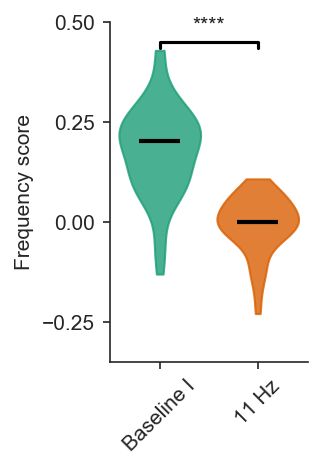

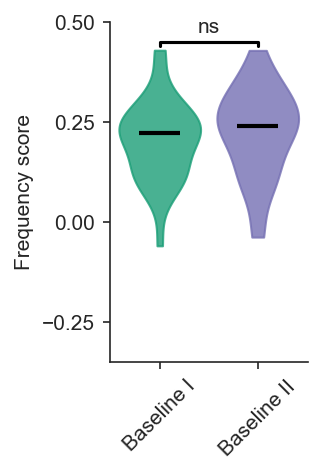

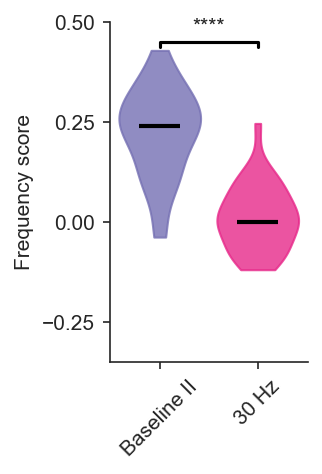

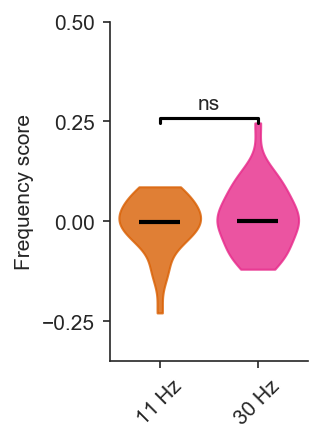

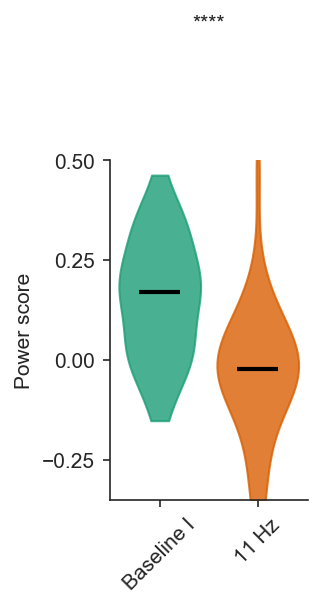

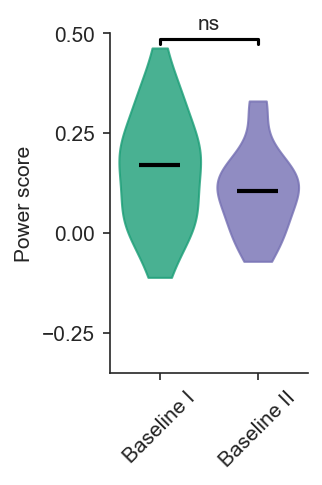

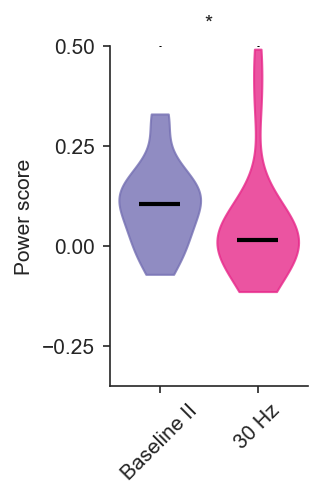

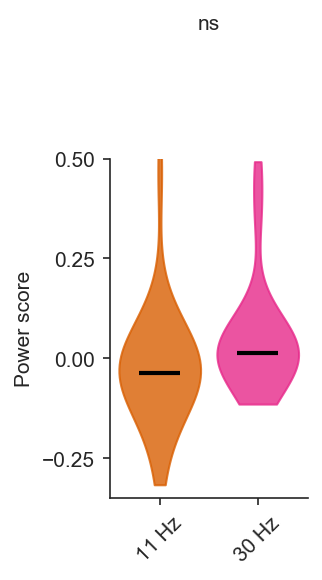

In [93]:
for stuff in ['freq_score', 'power_score']:
    for vs in vss:
        base, stim = results[stuff][vs].dropna().values.T
        plt.figure(figsize=figsize_violin)
        plt.ylabel(ylabel[stuff])
        violinplot(base, stim, colors=[colors[labels.index(l)] for l in vs], xticks=vs)
        plt.ylim(-0.35, 0.5)
        plt.yticks([-0.25, 0, 0.25, 0.5])
        despine()
        fig_path = output_path / "figures" / f"{stuff}_{' '.join(vs)}".replace(' ', '_')
        savefig(fig_path)
        

In [94]:
def plot_speed(results, stuff, colors, labels, filename=None, show_raw=False, ylim=None):
    base, stim = results[stuff][labels].dropna().values.T
    base_bins, stim_bins = results['speed_bins'][labels].dropna().values.T
    
    base = np.array([s for s in base])
    stim =  np.array([s for s in stim])
    
    if show_raw:
        fig, axs = plt.subplots(1, 2, sharey=True, figsize=figsize_speed)

        for b, h in zip(base_bins, base):
            axs[1].plot(b, h)
            axs[1].set_xlim(0.1,1)
            axs[1].set_title(labels[0])

        for b, h in zip(stim_bins, stim):
            axs[0].plot(b, h)
            axs[0].set_xlim(0.1,1)
            axs[0].set_title(labels[1])  

    fig, ax = plt.subplots(1, 1, figsize=figsize_speed)
    plot_bootstrap_timeseries(base_bins[0], base.T, ax=ax, label=labels[0], color=colors[0])
    plot_bootstrap_timeseries(stim_bins[0], stim.T, ax=ax, label=labels[1], color=colors[1])

    plt.xlim(0, 0.9)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(frameon=False)
    if ylim is not None:
        plt.ylim(ylim)
    despine()
    if filename is not None:
        savefig(output_path / "figures" / f"{filename}")

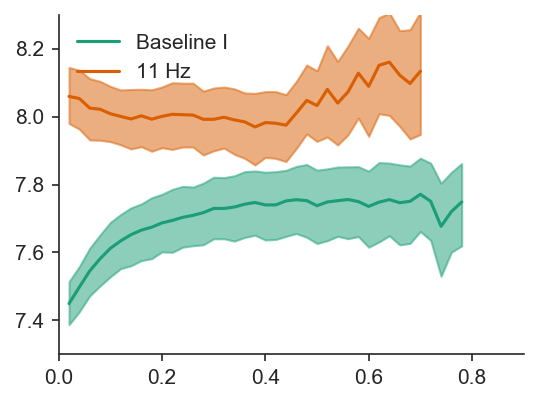

In [75]:
plot_speed(results, 'mean_freq', 
           colors[:2], labels[:2], filename='lfp_speed_freq_11', ylim=(7.3, 8.3))

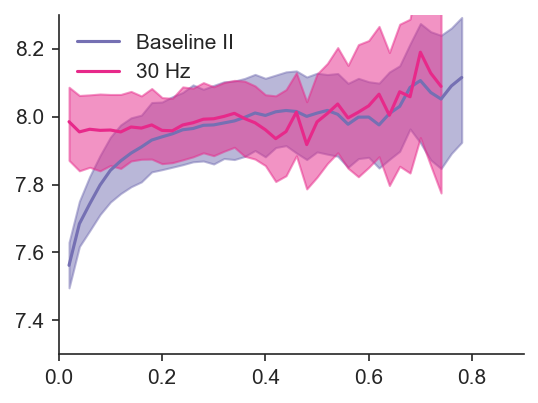

In [77]:
plot_speed(results, 'mean_freq', 
           colors[2:], labels[2:], filename='lfp_speed_freq_30', ylim=(7.3, 8.3))

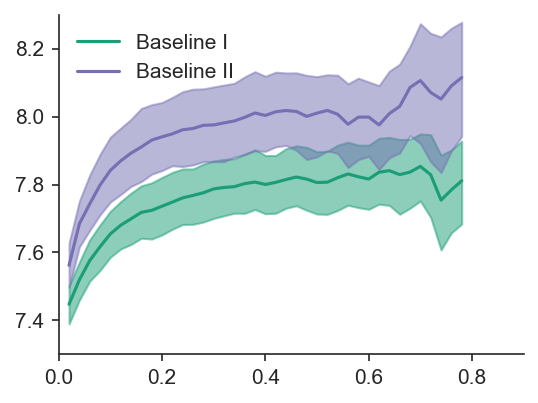

In [78]:
plot_speed(
    results, 'mean_freq', 
    colors=[colors[0], colors[2]], labels=[labels[0], labels[2]], filename='lfp_speed_freq_baseline', ylim=(7.3, 8.3))

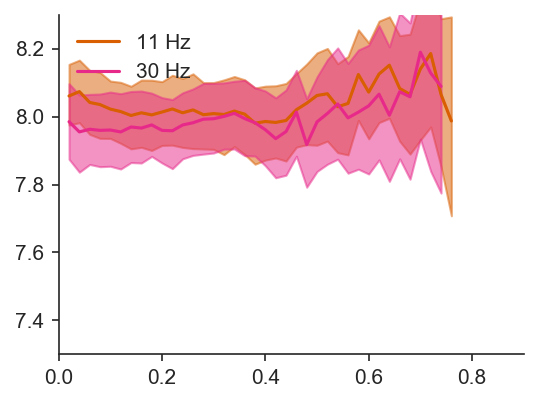

In [95]:
plot_speed(
    results, 'mean_freq', 
    colors=[colors[1], colors[3]], labels=[labels[1], labels[3]], filename='lfp_speed_freq_stim', ylim=(7.3, 8.3))

# Power Familiar

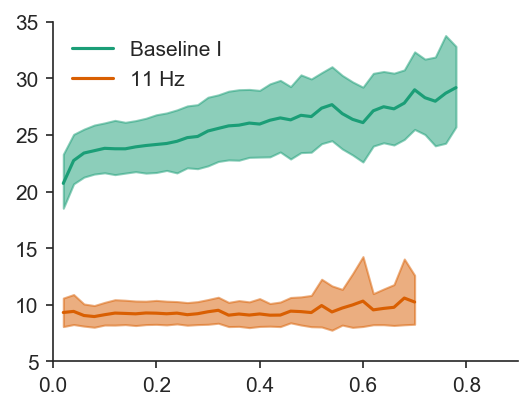

In [79]:
plot_speed(
    results, 'mean_power', 
    colors[:2], labels[:2], filename='lfp_speed_power_11', ylim=(5, 35))

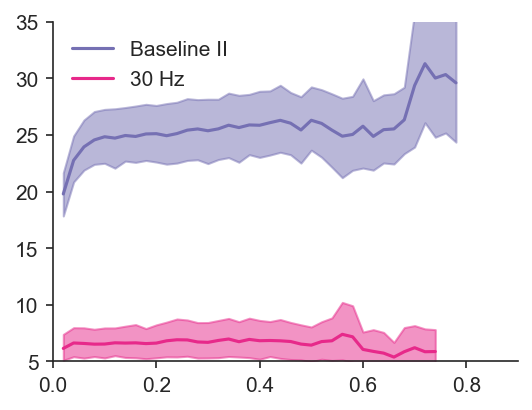

In [80]:
plot_speed(
    results, 'mean_power', 
    colors[2:], labels[2:], filename='lfp_speed_power_30', ylim=(5, 35))

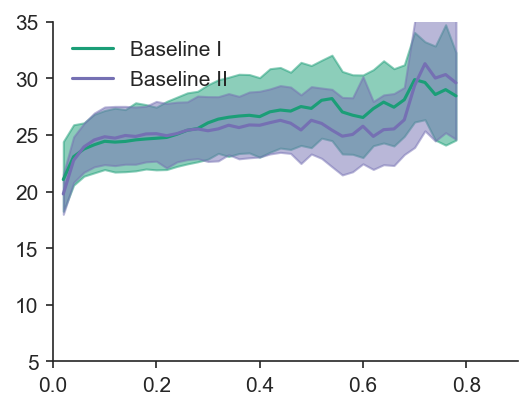

In [81]:
plot_speed(
    results, 'mean_power', 
    colors=[colors[0], colors[2]], labels=[labels[0], labels[2]], filename='lfp_speed_power_baseline', ylim=(5, 35))

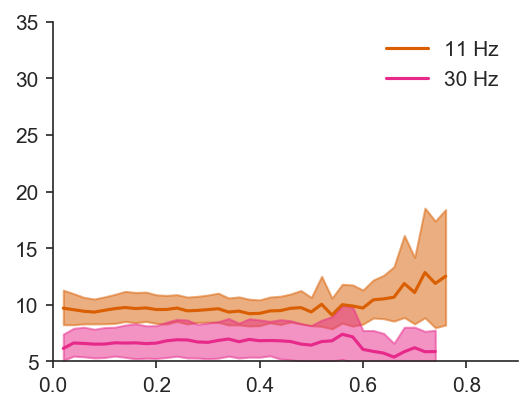

In [96]:
plot_speed(
    results, 'mean_power', 
    colors=[colors[1], colors[3]], labels=[labels[1], labels[3]], filename='lfp_speed_power_stim', ylim=(5, 35))

# Table

In [107]:
from septum_mec.analysis.statistics import make_statistics_table

In [110]:
stat, _ = make_statistics_table(
    {k:v for k, v in results.items() if k in ['power_score', 'freq_score']}, 
    labels, lmm_test=False, wilcoxon_test=True, use_weighted_stats=False, normality_test=True)
stat

,Freq score,Power score
Baseline I,0.183 ± 0.0166 (46),0.16 ± 0.022 (46)
Normality Baseline I,"3.38, 0.185","2.54, 0.281"
11 Hz,-0.00641 ± 0.0108 (44),-0.0221 ± 0.0303 (44)
Normality 11 Hz,"11, 0.00401","19.6, 5.51e-05"
Baseline II,0.224 ± 0.0196 (32),0.106 ± 0.0184 (32)
Normality Baseline II,"2.02, 0.365","1.21, 0.547"
30 Hz,0.0107 ± 0.0141 (34),0.0532 ± 0.0235 (34)
Normality 30 Hz,"2.81, 0.245","20.4, 3.72e-05"
Wilcoxon Baseline I - 11 Hz,"16, 2.27e-08, (44)","110, 7.02e-06, (44)"
Paired summary Baseline I - 11 Hz,"0.178 ± 0.017, -0.00641 ± 0.0108","0.154 ± 0.0226, -0.0221 ± 0.0303"


In [103]:
stat.to_latex(output_path / "statistics" / f"statistics.tex")
stat.to_csv(output_path / "statistics" / f"statistics.csv")

In [87]:
for key, result in results.items():
    result.to_latex(output_path / "statistics" / f"values_{key}.tex")
    result.to_csv(output_path / "statistics" / f"values_{key}.csv")

# Register in expipe

In [104]:
action = project.actions["lfp_speed"]

In [105]:
outdata = {
    "figures": "figures",
    "statistics": "statistics"
}

for key, value in outdata.items():
    action.data[key] = value
    data_path = action.data_path(key)
    data_path.parent.mkdir(exist_ok=True, parents=True)
    source = output_path / value
    if source.is_file():
        shutil.copy(source, data_path)
    else:
        copy_tree(str(source), str(data_path))

In [106]:
septum_mec.analysis.registration.store_notebook(action, "20_lfp_speed.ipynb")